In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import itertools

import numpy as np
import scipy as sp
import pandas as pd
import gudhi as gh
import networkx as nx

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

from src import depth
from src.depth import DepthPoset
from src.drow import plot_filtred_complex2d, plot_simplex, enumerate_points
from src.transpositions import Transposition

from tqdm.notebook import tqdm

import imageio as io
from PIL import Image

# Generate a Delauney Complex and 2 Filtrations on this

/tmp/ipykernel_18531/933326602.py:23: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  line, = axs[1].plot([0, 1], [filtration0[i], filtration1[i]], color=colors[i], label=simplices[i])
/tmp/ipykernel_18531/933326602.py:23: MatplotlibDeprecationWarning: Passing label as a length 3 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  line, = axs[1].plot([0, 1], [filtration0[i], filtration1[i]], color=colors[i], label=simplices[i])


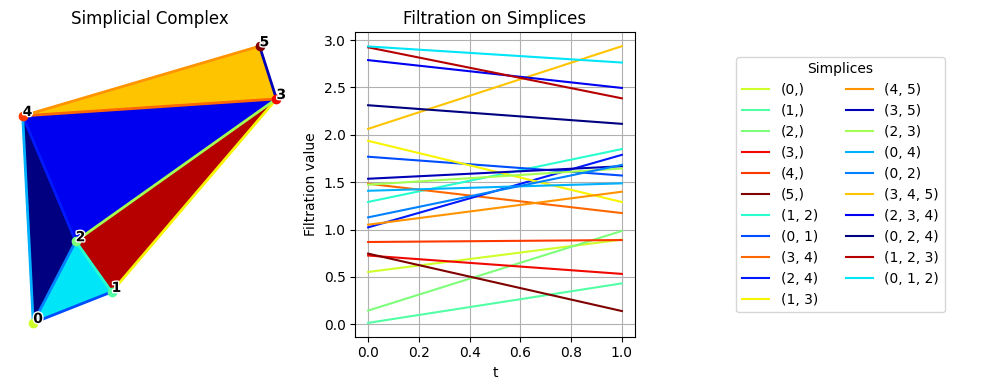

In [3]:
n = 6
complex_dimension = 2
points = np.random.random([n, complex_dimension])

simplices = np.array([tuple(s) for s, _ in gh.AlphaComplex(points).create_simplex_tree().get_simplices()], dtype=object)
simplices = simplices[np.argsort([len(s) for s in simplices])]
dims = np.vectorize(len)(simplices) - 1

filtration0 = np.random.random(len(simplices)) + dims
filtration1 = np.random.random(len(simplices)) + dims

fig, axs = plt.subplots(1, 3, figsize=(10, 4))

colors = np.linspace(0, 1, len(simplices))
colors = np.random.choice(colors, len(colors), replace=False)
colors = plt.get_cmap('jet')(colors)
lines = []
labels = []

for i in range(len(simplices)):
    plot_simplex(list(simplices[i]), points, color=colors[i], ax=axs[0])
    
    line, = axs[1].plot([0, 1], [filtration0[i], filtration1[i]], color=colors[i], label=simplices[i])
    lines.append(line)
    labels.append(str(simplices[i]))

axs[0].set_title('Simplicial Complex')
axs[0].axis('off')
enumerate_points(points, ax=axs[0], weight='semibold', forewidth=2)

axs[1].set_title('Filtration on Simplices')
axs[1].set_xlabel('t')
axs[1].set_ylabel('Filtration value')
axs[1].grid(True)

axs[2].axis('off')
axs[2].legend(lines, labels, loc='center', title="Simplices", ncol=np.ceil(len(simplices)/18))

plt.tight_layout()
plt.show()

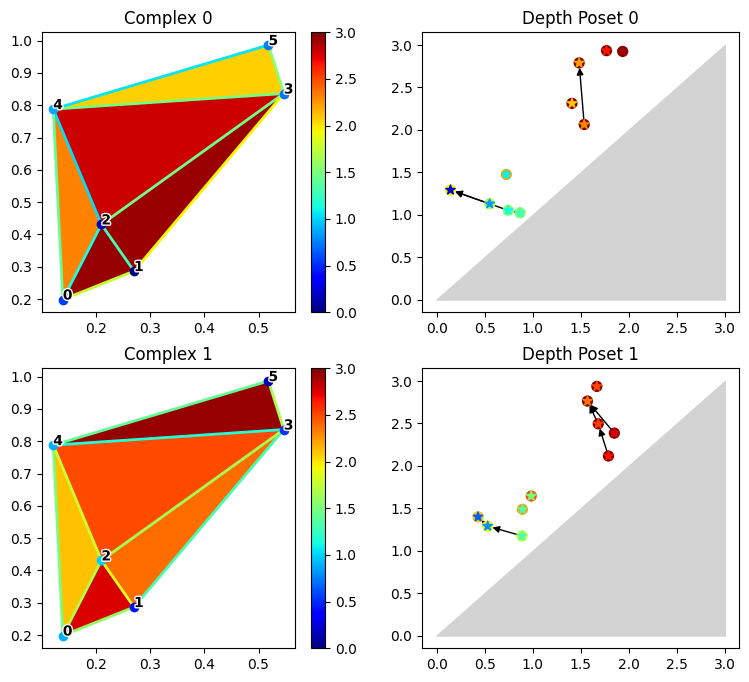

In [4]:
stree0 = gh.SimplexTree()
for simplex, value in zip(simplices, filtration0):
    stree0.insert(simplex, value)
dp0 = DepthPoset.from_simplex_tree(stree0)

stree1 = gh.SimplexTree()
for simplex, value in zip(simplices, filtration1):
    stree1.insert(simplex, value)
dp1 = DepthPoset.from_simplex_tree(stree1)

cmap = plt.get_cmap('jet')
fig, axs = plt.subplots(2, 2, figsize=(9, 8))
for i, (streei, dpi) in enumerate(zip([stree0, stree1], [dp0, dp1])):
    axs[i, 0].set_title(f'Complex {i}')
    sm = plot_filtred_complex2d(streei, points, ax=axs[i, 0], cmap=cmap, vmin=0, vmax=complex_dimension+1)
    plt.colorbar(sm, ax=axs[i, 0])
    enumerate_points(points, ax=axs[i, 0], weight='semibold', forewidth=2)
    
    birth_colors = [cmap(streei.filtration(node.source[0])/complex_dimension) for node in dpi.nodes]
    death_colors = [cmap(streei.filtration(node.source[1])/complex_dimension) for node in dpi.nodes]

    axs[i, 1].set_title(f'Depth Poset {i}')
    nx.draw_networkx_edges(dpi.get_transitive_reduction(), pos=dpi.persistant_layout(), ax=axs[i, 1], 
                           node_size=50, hide_ticks=False)
    nx.draw_networkx_nodes(dpi.get_transitive_reduction(), pos=dpi.persistant_layout(), ax=axs[i, 1], 
                           node_size=50, node_shape='o', node_color=death_colors, hide_ticks=False)
    nx.draw_networkx_nodes(dpi.get_transitive_reduction(), pos=dpi.persistant_layout(), ax=axs[i, 1], 
                           node_size=50, node_shape='*', node_color=birth_colors, hide_ticks=False)
    
    axs[i, 1].fill_between([0, complex_dimension + 1], [0, 0], [0, complex_dimension + 1], color='lightgrey')

# Defining Transposition Functions

## Catch the Difference betweeen Depth Posets

In [5]:
def depth_posets_are_different(dp0, dp1):
    # 
    nodes0 = set([node.source for node in dp0.nodes])
    nodes1 = set([node.source for node in dp1.nodes])
    if nodes0 != nodes1:
        return True
    edges0 = set([(node0.source, node1.source) for node0, node1 in dp0.edges])
    edges1 = set([(node0.source, node1.source) for node0, node1 in dp1.edges])
    if edges0 != edges1:
        return True
    return False

In [6]:
depth_posets_are_different(dp0, dp1)

True

# Define the Transposition Moments

In [7]:
def get_cross_parameters(y0, y1, t0=0, t1=1, filter_outside=True):
    """
    Returns the matrix of cross parameters between two arrays.

    Parameters:
        y0, y1: two arrays of the same length
        t0, t1: the time points for the arrays
        filter_outside: if True, filter out the values outside the range [t0, t1]

    Returns:
        cross_parameters: the matrix of cross parameters
    """
    y0 = np.asarray(y0)
    y1 = np.asarray(y1)
    if y0.shape != y1.shape:
        raise ValueError("Arrays must have the same length.")
    if y0.ndim != 1:
        raise ValueError("Arrays must be 1D.")
    
    yi0 = y0.reshape(-1, 1)
    yi1 = y1.reshape(-1, 1)
    yj0 = y0.reshape(1, -1)
    yj1 = y1.reshape(1, -1)

    cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


    if filter_outside:
        cross_parameters[cross_parameters < min(t0, t1)] = np.nan
        cross_parameters[cross_parameters > max(t0, t1)] = np.nan
    return cross_parameters

In [8]:
cross_parameters = [get_cross_parameters(filtration0[dims == i], filtration1[dims == i]) for i in range(complex_dimension + 1)]

eps = 0.8*min([min(np.unique(np.triu(i))[1:-1] - np.unique(np.triu(i))[:-2]) for i in cross_parameters])


/tmp/ipykernel_18531/49407725.py:25: RuntimeWarning: invalid value encountered in divide
  cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


In [9]:


df_transpositions = []
for dim, cross_parameters_dim in enumerate(cross_parameters):
    for i0, i1 in np.argwhere(~np.isnan(cross_parameters_dim) & np.triu(np.ones(cross_parameters_dim.shape, dtype=bool))):
        # define time and filtration value
        time = cross_parameters_dim[i0, i1]
        filtration_value = filtration0[dims == dim][i0]*(1 - time) + filtration1[dims == dim][i0]*time

        # define simplices
        simplex0 = simplices[dims == dim][i0]
        simplex1 = simplices[dims == dim][i1]

        # define the complex and the depth poset before the transposition
        time_before = time - eps
        filtration_before = filtration0*(1 - time_before) + filtration1*time_before
        stree_before = gh.SimplexTree()
        for simplex, value in zip(simplices, filtration_before):
            stree_before.insert(simplex, value)
        dp_before = DepthPoset.from_simplex_tree(stree_before)

        # define the complex and the depth poset after the transposition
        time_after = time + eps
        filtration_after = filtration0*(1 - time_after) + filtration1*time_after
        stree_after = gh.SimplexTree()
        for simplex, value in zip(simplices, filtration_after):
            stree_after.insert(simplex, value)
        dp_after = DepthPoset.from_simplex_tree(stree_after)

        # initialize transposition
        df_transpositions.append(
            {   
                'time': time,
                'value': filtration_value, 
                'transposition object': Transposition.from_simplex_tree(stree_before, simplex0, simplex1), 
                'changing': depth_posets_are_different(dp_before, dp_after)
            }
        )

for i in range(len(df_transpositions)):
    df_transpositions[i].update(df_transpositions[i]['transposition object'].to_dict())



df_transpositions = pd.DataFrame(df_transpositions)
df_transpositions = df_transpositions.sort_values('time')

df_transpositions.loc[(df_transpositions['switch'] == 'switch forward') | (df_transpositions['switch'] == 'switch backward'), 'switch'] = 'switch'

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

self.index1 - self.index0 != 1
df_transpositions.shape = (44, 11)


,time,value,transposition object,changing,index 0,index 1,cell 0,cell 1,dim,type,switch
22,0.020699,1.477358,"<(2, 3), (3, 4)>",True,11,12,"(2, 3)","(3, 4)",1,birth-death,switch
8,0.048604,0.716192,"<(3,), (5,)>",False,3,4,"(3,)","(5,)",0,birth-birth,no switch
26,0.067579,1.074647,"<(2, 4), (4, 5)>",True,6,7,"(2, 4)","(4, 5)",1,death-death,switch
23,0.191624,1.424412,"<(0, 4), (3, 4)>",False,10,11,"(0, 4)","(3, 4)",1,birth-death,no switch
3,0.204304,0.621755,"<(0,), (5,)>",False,2,3,"(0,)","(5,)",0,birth-birth,no switch


In [10]:
df_transpositions[['changing', 'type', 'switch']].value_counts(dropna=False).reset_index().pivot_table(index=['type', 'switch'], columns='changing', values='count').fillna(0).astype(int)

changing                  False  True 
type           switch                 
birth-birth    no switch     11      6
               switch         0      1
birth-death    no switch      6      0
               switch         0      4
birth-unpaired undefined      0      1
death-death    no switch      7      4
               switch         0      4

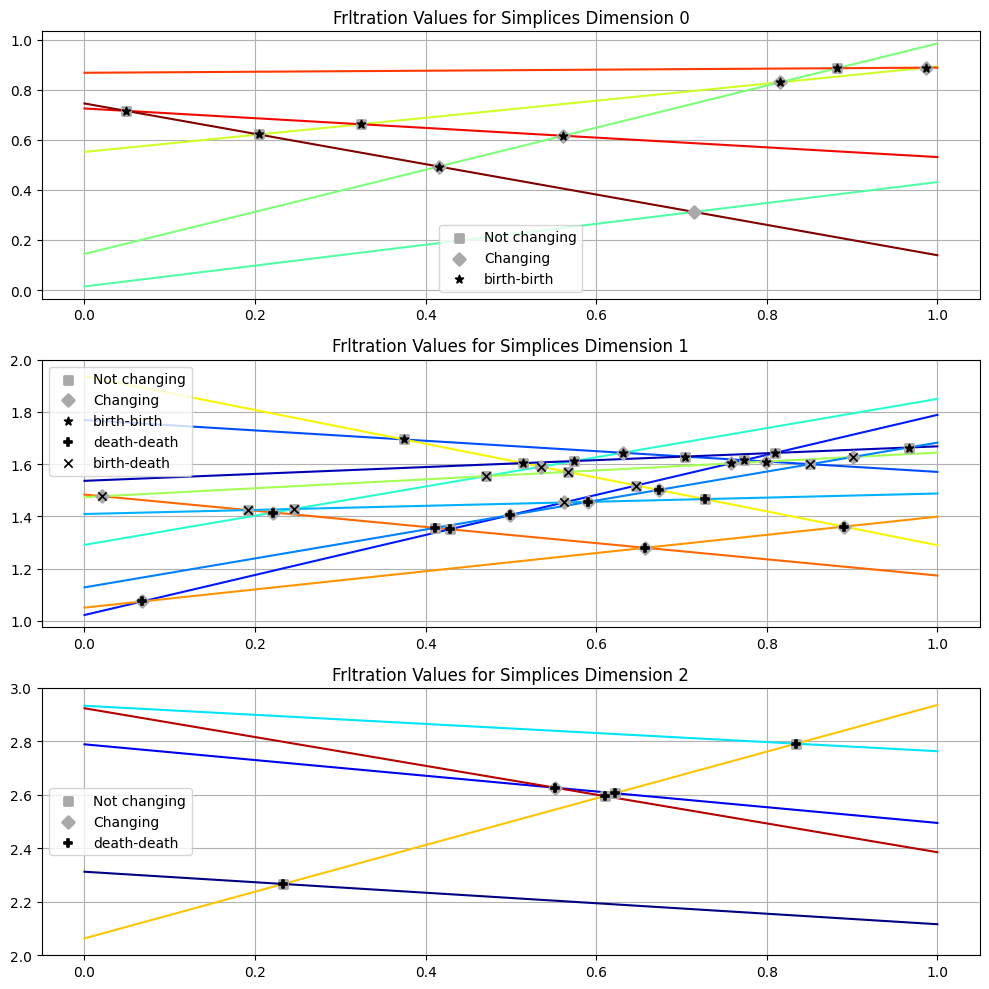

In [11]:
fig, axs = plt.subplots(3, figsize=[10, 10])

for dim in range(3):
    axs[dim].set_title(f'Frltration Values for Simplices Dimension {dim}')
    for simplex, y0, y1, color in zip(simplices[dims == dim], filtration0[dims == dim], filtration1[dims == dim], colors[dims == dim]):
        axs[dim].plot([0, 1], [y0, y1], color=color)
    
    x = df_transpositions[(df_transpositions['dim'] == dim)&~df_transpositions['changing']]['time']
    y = df_transpositions[(df_transpositions['dim'] == dim)&~df_transpositions['changing']]['value']
    if len(x) > 0:
        axs[dim].scatter(x, y, color='darkgrey', marker='s', label='Not changing', linewidth=2, zorder=2)

    x = df_transpositions[(df_transpositions['dim'] == dim)&df_transpositions['changing']]['time']
    y = df_transpositions[(df_transpositions['dim'] == dim)&df_transpositions['changing']]['value']
    if len(x) > 0:
        axs[dim].scatter(x, y, color='darkgrey', marker='D', label='Changing', linewidth=2, zorder=2)


    for transposition_type, marker in zip(['birth-birth', 'death-death', 'birth-death'], '*Px'):
        dfi = df_transpositions[(df_transpositions['dim'] == dim) & 
                                (df_transpositions['type'] == transposition_type)]
        x = dfi['time']
        y = dfi['value']
        if len(x) > 0:
            axs[dim].scatter(x, y, marker=marker, color='black', zorder=2, label=transposition_type, linewidth=1.2)
    
    axs[dim].set_yticks(np.linspace(dim, dim + 1, 6))
    axs[dim].grid(True)
    axs[dim].legend()

plt.tight_layout()
plt.show()